Embedding 2730 mouse bone marrow cells with PHATE<br>
Paper: <a href="http://www.biorxiv.org/content/early/2017/03/24/120378">PHATE: A Dimensionality Reduction Method for Visualizing Trajectory Structures in High-Dimensional Biological Data</a><br>
Code: https://github.com/KrishnaswamyLab/PHATE<br>
Data: <a href="https://www.ncbi.nlm.nih.gov/pubmed/26627738">Paul F., et al. Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors. Cell. 2015.</a>

In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn
import pandas as pd

In [2]:
# computes kernel and operator
def get_operator(data=None, k=5, a=10):
    pdx = squareform(pdist(data, metric='euclidean')) # compute distances on pca
    knn_dst = np.sort(pdx, axis=1) # get knn distances for adaptive kernel
    epsilon = knn_dst[:,k] # bandwidth(x) = distance to k-th neighbor of x
    pdx = (pdx / epsilon).T # autotuning d(x,:) using epsilon(x).
    gs_ker = np.exp(-1 * ( pdx ** a)) # alpha decaying Gaussian kernel: exp(-D^alpha)
    gs_ker = gs_ker + gs_ker.T # symmetrization
    diff_deg = np.diag(np.sum(gs_ker,0)) # degrees
    diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),gs_ker) # row stochastic -> Markov operator
    return diff_op

In [3]:
# load data
clusters = pd.read_csv("~/git_projects/PHATE/data/MAP.csv", header=None)
clusters.columns = pd.Index(['wells', 'clusters'])
bmmsc = pd.read_csv("~/git_projects/PHATE/data/BMMC_myeloid.csv.gz", index_col=0)
C = clusters['clusters'] #using cluster labels from original publication

In [4]:
# library size normalization
data = bmmsc.as_matrix()
lib_size = data.sum(axis=1)
data = data / lib_size[:,None] # divide by library size
data = data * np.median(lib_size) # multiply by median library size
bmmsc_norm = pd.DataFrame(data=data, columns=bmmsc.columns.tolist())

In [33]:
# PCA
npca = 20
pca = PCA(n_components=npca, svd_solver='randomized') # fast random PCA
pc = pca.fit_transform(bmmsc_norm.as_matrix())

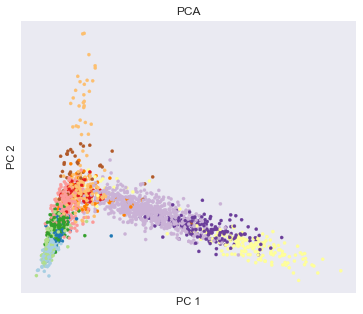

In [34]:
# plot PCA
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
plt.setp(ax, xticks=[], yticks=[])
ax.scatter(pc[:,0], pc[:,1], s=10, c=C, cmap="Paired")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("PCA")
plt.show()

In [7]:
# tSNE
tsne = TSNE().fit_transform(pc)

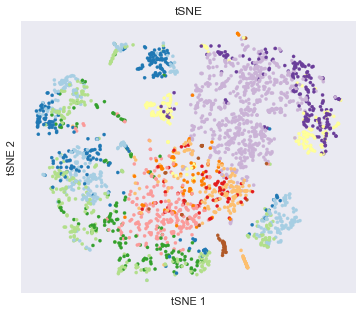

In [8]:
# plot tSNE
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
plt.setp(ax, xticks=[], yticks=[])
ax.scatter(tsne[:,0], tsne[:,1], s=10, c=C, cmap="Paired")
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")
ax.set_title("tSNE")
plt.show()

In [9]:
# PHATE params
k = 4; # neighbors for adaptive kernel
a = 10; # decay of kernel
t = 40 # number of steps to diffuse
seed = 7 # random seed

In [10]:
# compute operator for PHATE
diff_op = get_operator(data=pc, k=k, a=a)

In [11]:
# PHATE potential
X = np.linalg.matrix_power(diff_op, t) # power operator
X[X == 0] = np.finfo(float).eps # handling zeros
X[X <= np.finfo(float).eps] = np.finfo(float).eps # handling small values
diff_potential = -1*np.log(X) # diffusion potential (-log(M))

In [12]:
# PHATE embed using classical MDS
pdx = squareform(pdist(diff_potential, 'euclidean'))
# center matrix
pdx_cent = np.array(pdx)
pdx_cent -= pdx_cent.mean(axis = 0)
pdx_cent -= pdx_cent.mean(axis = 1)
pca = PCA(n_components=3, svd_solver='randomized') # fast random PCA
Y_cmds = pca.fit_transform(pdx_cent)

In [13]:
# PHATE embed using metric MDS (2D)
Y_mmds = MDS(n_components=2, metric=True, max_iter=3000, eps=1e-12,
             dissimilarity="precomputed", random_state=seed, n_init=1).fit_transform(pdx)

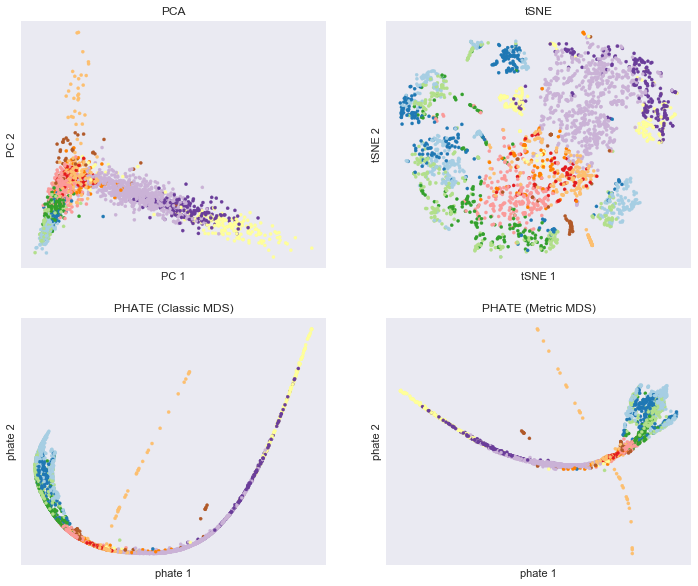

In [14]:
# plot everything
f, axes = plt.subplots(2,2)

f.set_size_inches(12,10)
plt.setp(axes, xticks=[], xticklabels=[], yticks=[])
ax1, ax2, ax3, ax4 = axes.ravel()

#plotting PCA
ax1.scatter(pc[:,0], pc[:,1], s=10, c=C, cmap="Paired")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.set_title("PCA")

#plotting tSNE
ax2.scatter(tsne[:,0], tsne[:,1], s=10, c=C, cmap="Paired")
ax2.set_xlabel("tSNE 1")
ax2.set_ylabel("tSNE 2")
ax2.set_title("tSNE")

#plotting PHATE - classic MDS
ax3.scatter(Y_cmds[:,0], Y_cmds[:, 1], s=10, c=C, cmap="Paired")
ax3.set_xlabel("phate 1")
ax3.set_ylabel("phate 2")
ax3.set_title("PHATE (Classic MDS)")

#plotting PHATE - metric MDS
ax4.scatter(Y_mmds[:,0], Y_mmds[:, 1], s=10, c=C, cmap="Paired")
ax4.set_xlabel("phate 1")
ax4.set_ylabel("phate 2")
ax4.set_title("PHATE (Metric MDS)")

plt.show()

In [15]:
# PHATE embed using metric MDS (3D)
Y_mmds_3D = MDS(n_components=3, metric=True, max_iter=3000, eps=1e-12,
             dissimilarity="precomputed", random_state=seed, n_init=1).fit_transform(pdx)

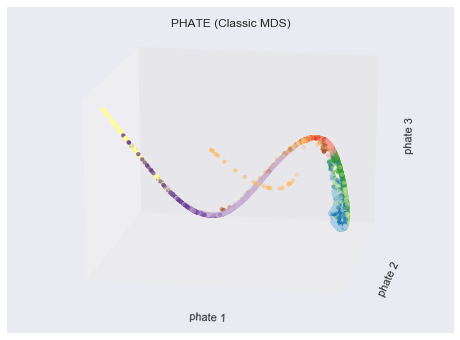

In [41]:
# plot in PHATE CMDS in 3D
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')
plt.setp(ax, xticks=[], yticks=[], zticks=[])
ax.scatter(Y_cmds[:, 0], Y_cmds[:, 1], Y_cmds[:, 2], s=15, cmap="Paired", c=C)
ax.set_xlabel("phate 1")
ax.set_ylabel("phate 2")
ax.set_zlabel("phate 3")
ax.set_title("PHATE (Classic MDS)")
ax.view_init(20, 100)

plt.show()